##Mask Detection

© 2024, Zaka AI, Inc. All Rights Reserved.

---
The goal of this project is to build a model that can detect whether a person is wearing a mask or not. You would be downloading the data from kaggle and then building you model while we guide you through the steps.


##Getting the Data

We start by getting the data. The data that we want is on kaggle and you can access it through this link: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset What you will have to do, is to search for a way that allows you to download the dataset from kaggle directly into google colab (or your google drive). This process would save you the trouble from downloading the dataset locally and then uploading it to use it in colab.

In [ ]:
#Do your Research

# Installing Kaggle
!pip install kaggle

# Uploading kaggle API key file
from google.colab import files
files.upload()

# Moving the key file to the correct directory and setting permissions
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# I am going to download the dataset to my drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading the dataset to my google drive
!kaggle datasets download -d omkargurav/face-mask-dataset -p /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 97% 159M/163M [00:01<00:00, 101MB/s] 
100% 163M/163M [00:01<00:00, 94.7MB/s]


Once the dataset is downloaded, it is going to be zipped, and in order to use it, you need to unzip it. Here you have the option of unzipping it in the environment or in your google drive.

In [ ]:
# Unzipping to the same folder in google drive
!unzip /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets/face-mask-dataset.zip -d /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets/data/with_mask/with_mask_3297.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets/data/with_mask/with_mask_3298.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets/data/with_mask/with_mask_3299.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets/data/with_mask/with_mask_33.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets/data/with_mask/with_mask_330.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets/data/with_mask/with_mask_3300.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets/data/with_mask/with_mask_3301.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets/data/with_mask/with_mask_3302.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebo

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets/

/content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets


##Importing the Libraries

Now, it is time to import the libraries that we need.

In [ ]:
import os
import shutil
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2

If we look at the data that we extracted, we can see that it is located in 2 folders: with_mask and without_mask. What we need to do now, is to create a hierarchy of folders that would help us specify the training, validation, and testing data. In order to do this you have to use the **os** and the **shutil** libraries that would help you creating folders, and moving images from a folder to another. In simple terms, the libraries helps you perform the same things that you do on your computer with your operating system, but in a programmatic way.

The initial dataset contains a lot of images belonging to the 2 classes, what we will do is randomly sample from this dataset so that we reduce the training and the tuning time.

We need to have in our final directories the following:
* Training: 500 images "with_mask", and 500 images "without_mask"
* Validation: 100 images "with_mask", and 100 images "without_mask"
* Testing: 50 images "with_mask", and 50 images "without_mask"

In [ ]:
#Test Your Zaka --- Create the Train, Validation and Testing Folder

# Defining the paths for the 3 folders to use later
base_path = '/content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets'

# Creating the 3 directories
os.makedirs(f'{base_path}/training')
os.makedirs(f'{base_path}/validation')
os.makedirs(f'{base_path}/testing')

# Checking if folders were created
!ls /content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets

data  face-mask-dataset.zip  testing  training	validation


In [ ]:
#Test Your Zaka --- Create the classes folders inside of each folder you created above

base_path = '/content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets'

# Define the main folders
folders = ['training', 'validation', 'testing']

# Defining mask and without mask folders
classes = ['with_mask', 'without_mask']

# Creating the new folders inside each
for folder in folders:
    folder_path = f'{base_path}/{folder}'
    for class_name in classes:
        class_folder_path = f'{folder_path}/{class_name}'
        os.makedirs(class_folder_path)

In [ ]:
#Test Your Zaka --- For each class, take the images, and select 500 samples for training and 100 for evaluation, and 50 for testing

base_path = '/content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets'
data_path = f'{base_path}/data'

# Defining the number of images required for each folder
split_counts = {
    'training': 500,
    'validation': 100,
    'testing': 50
}

# Using the created folders' paths
splits = {
    'training': f'{base_path}/training',
    'validation': f'{base_path}/validation',
    'testing': f'{base_path}/testing'
}

# Specifying the 2 classess
classes = ['with_mask', 'without_mask']


for class_name in classes:
    # Getting the source folder for the class (original data folder)
    class_data_path = f'{data_path}/{class_name}'

    # Geting all image filenames
    images = os.listdir(class_data_path)
    random.shuffle(images)  # Shuffling the images for randomness

    # Assigning images according to the required splits (500, 100, 50)
    start_idx = 0
    for split, count in split_counts.items():
        # Defining the destination folder
        dest_path = f'{splits[split]}/{class_name}'

        # Selecting the required number of images for this split
        split_images = images[start_idx:start_idx + count]
        start_idx += count

        # Copying images to the destination folder using shutil
        for img in split_images:
            shutil.copy(f'{class_data_path}/{img}', f'{dest_path}/{img}')

print("Images have been successfully copied to the train, validation, and test folders!")

Images have been successfully copied to the train, validation, and test folders!


##Inspecting the Dataset

Now we will see some characteristics of our dataset.

Define 3 variables: **training_path**, **validation_path**, and **testing_path** so that you can use them for the rest of the colab.

In [ ]:
# Creating the variables to hold the paths of 3 folders
base_path = '/content/drive/MyDrive/Colab_Notebooks/ZAKA_AIC/Kaggle_Datasets'

training_path = f'{base_path}/training'
validation_path = f'{base_path}/validation'
testing_path = f'{base_path}/testing'

To make sure that everythinh went correctly, write a code that counts the number of images that you have in your training directory for each of the 2 categories: with_mask and without_mask

In [ ]:
classes = ['with_mask', 'without_mask']

# Counting the number of images in each class of training folder
for class_name in classes:
    class_path = os.path.join(training_path, class_name)  # Full path to the category folder
    num_images = len(os.listdir(class_path))  # Count the files in the category folder
    print(f"Number of images in '{class_name}': {num_images}")

Number of images in 'with_mask': 500
Number of images in 'without_mask': 500


Do the same for the validation and the testing folders

In [ ]:
# Counting the number of images in each class of validation folder
for class_name in classes:
    class_path = os.path.join(validation_path, class_name)  # Full path to the category folder
    num_images = len(os.listdir(class_path))  # Count the files in the category folder
    print(f"Number of images in '{class_name}': {num_images}")

Number of images in 'with_mask': 100
Number of images in 'without_mask': 100


In [ ]:
# Counting the number of images in each class of testing folder
for class_name in classes:
    class_path = os.path.join(testing_path, class_name)  # Full path to the category folder
    num_images = len(os.listdir(class_path))  # Count the files in the category folder
    print(f"Number of images in '{class_name}': {num_images}")

Number of images in 'with_mask': 50
Number of images in 'without_mask': 50


Write a code that shows 5 random images for people with mask from your training set.

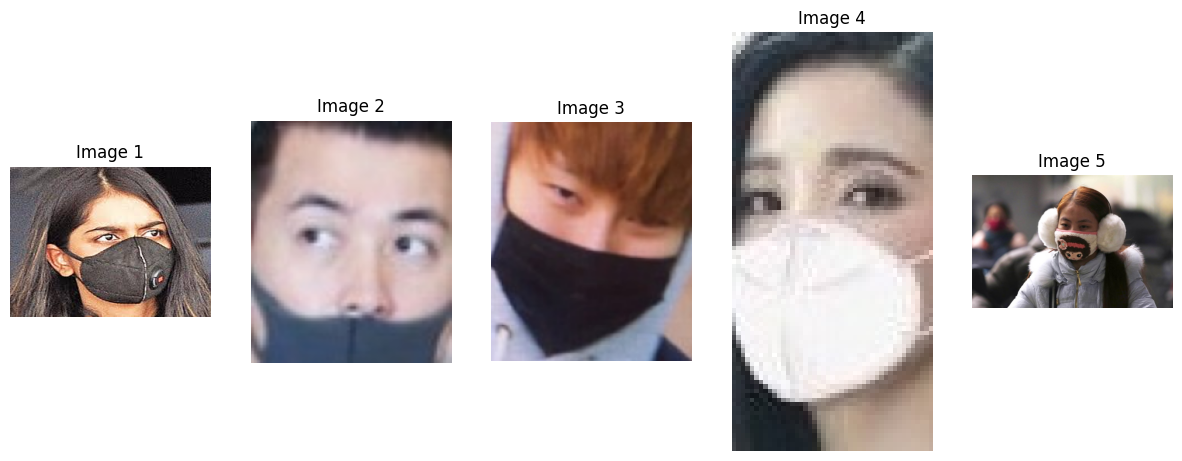

In [ ]:
from PIL import Image

# Defining the path to the training set for 'mask'
with_mask_training_path = f'{training_path}/with_mask'

# Getting all image filenames in the 'mask' category
mask_images = os.listdir(with_mask_training_path)

# Selecting 5 random images
random_images = random.sample(mask_images, 5)

# Plotting the images
plt.figure(figsize=(15, 10))
for i, image_name in enumerate(random_images):
    image_path = os.path.join(with_mask_training_path, image_name)  # Full path to the image
    img = Image.open(image_path)  # using PIL to open the image
    plt.subplot(1, 5, i + 1)  # subplot for each image
    plt.imshow(img)
    plt.axis('off')  # Turn off axes
    plt.title(f"Image {i+1}")  # Add title
plt.show()


Do the same for people without mask.

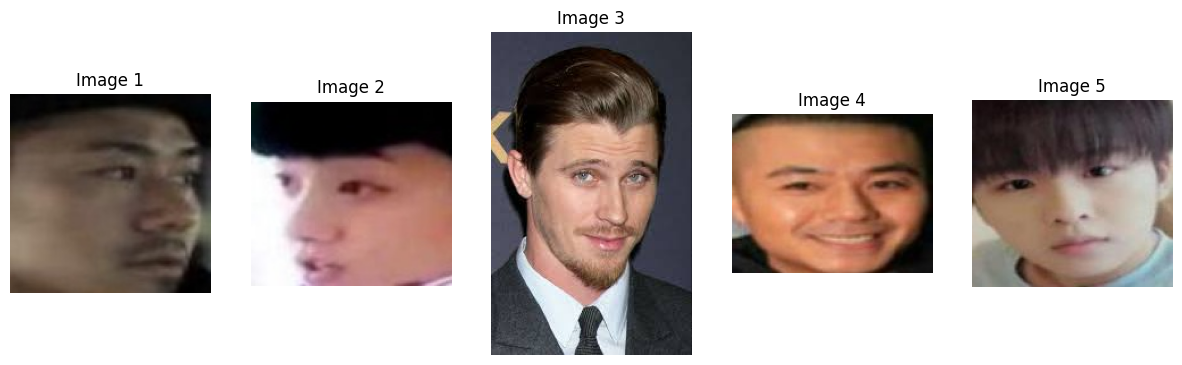

In [ ]:
without_mask_training_path = f'{training_path}/without_mask'

without_mask_images = os.listdir(without_mask_training_path)

random_images = random.sample(without_mask_images, 5)

# Plotting the images
plt.figure(figsize=(15, 10))
for i, image_name in enumerate(random_images):
    image_path = os.path.join(without_mask_training_path, image_name)
    img = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1}")
plt.show()

##Modeling

In [ ]:
# ------------------- First I will preprocess the images using ImageDataGenerator ------------------------------ #
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing for training data
training_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalizing and trying other augmentation techniques
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
)

# Normalizing validation and testing data
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
testing_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create generators for loading data
train_generator = training_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),  # I will try resizing all images to 128x128
    batch_size=64,  # Number of images per batch
    class_mode='binary'  # Use binary class mode for 2 classes
)

# Doing the same for validation and testing data

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=64,
    class_mode='binary'
)

test_generator = testing_datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=64,
    class_mode='binary',
    shuffle=False  # Not shuffling for testing (for consistent evaluation)
)


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Define a model structure that can deal with the images that we have to classify them between the 2 classes.

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Defining the CNN model - 2 convolution layers and 2 dense

model = models.Sequential([

    # Input layer
    layers.Input(shape=(128, 128, 3)),

    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), activation='relu'),  # 32 filters, 3x3 kernel
    layers.MaxPooling2D((2, 2)),  # Max pooling

    # Convolutional Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),  # 64 filters
    layers.MaxPooling2D((2, 2)),

    # Flatten the feature maps
    layers.Flatten(),

    # Fully Connected Layer 1
    layers.Dense(128, activation='relu'),  # 128 neurons
    layers.Dropout(0.5),  # Dropout to prevent overfitting

    # Fully Connected Layer 2 (Output Layer)
    layers.Dense(1, activation='sigmoid')  # binary classification
])

# Compiling the model
model.compile(
    optimizer=Adam(learning_rate = 0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']  # Metrics to monitor classification performance
)

# Printing the model summary
model.summary()


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_59 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_59 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_60 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Train the model that you defined on the training data and evaluate it on the validation data. Feel free to tune the hyperparameters of your model until you reach a satisfying result on the validation set. </br>
**N.B:** Make sure to save the model training history in a variable to plot later the learning curve.

In [ ]:
# Training the model using the preprocessed data

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,  # Training data generator
    validation_data=validation_generator,  # Validation data generator
    epochs=20,  # Number of epochs to train
    callbacks=[early_stopping]
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8370 - loss: 0.3724 - precision: 0.8473 - recall: 0.8113 - val_accuracy: 0.9250 - val_loss: 0.2157 - val_precision: 0.9670 - val_recall: 0.8800
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8425 - loss: 0.3759 - precision: 0.8701 - recall: 0.8169 - val_accuracy: 0.9300 - val_loss: 0.1934 - val_precision: 0.9674 - val_recall: 0.8900
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8538 - loss: 0.3588 - precision: 0.8773 - recall: 0.8243 - val_accuracy: 0.9350 - val_loss: 0.1922 - val_precision: 0.9579 - val_recall: 0.9100
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8615 - loss: 0.3448 - precision: 0.8575 - recall: 0.8479 - val_accuracy: 0.9350 - val_loss: 0.1951 - val_precision: 0.9223 - val_recall: 0.9500
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8495 - loss: 0.3720 - precision: 0.8573 - recall: 0.8556 - val_accuracy: 0.9400 - val_loss: 0.2052 - val

Plot the accuracy curve and see if your model is overfit.

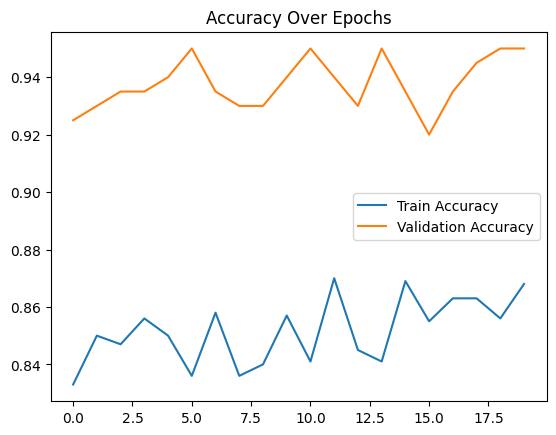

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

The pattern of increase for the training and validation accuracies are almost similar but they both show some instability. Vilidation accuracy is not lower than training accuracy which suggests the model is not overfitting, however, I am not sure how to interpret validation accuracy being higher than the training one (and the gap between them).

##Evaluate the model


Now you will evaluate the model that you built on the testing set that you kept aside since the beginning.

In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")
print(f"Test Precision: {test_precision}, Test Recall: {test_recall}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.9140 - loss: 0.2533 - precision: 0.8671 - recall: 0.9095
Test Accuracy: 0.9100000262260437, Test Loss: 0.25431710481643677
Test Precision: 0.918367326259613, Test Recall: 0.8999999761581421


Now we want to visualize the confusion matrix in order to see how much our classifier is good in predicting different classes.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
Confusion Mtrix:
  [[46  4]
 [ 5 45]]


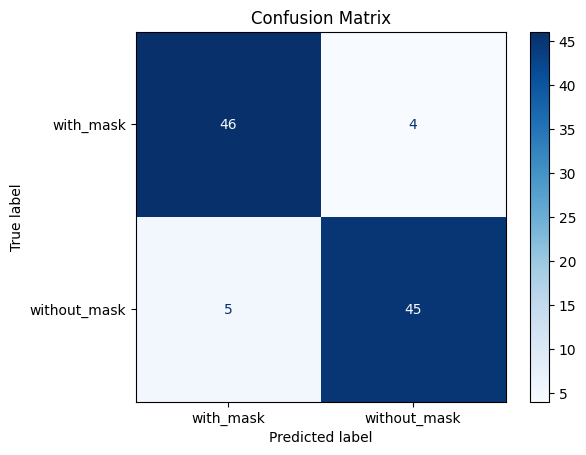

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Getting the predicted values
predictions = model.predict(test_generator)

# Converting probabilities to binary predictions
y_pred = (predictions > 0.5).astype(int).flatten()

# Getting the true labels from the test generator
y = test_generator.classes

# Computing the confusion matrix
conf_mat = confusion_matrix(y, y_pred)
print('Confusion Mtrix:\n ', conf_mat)

# Defining the class labels (adjust if needed)
class_labels = ['with_mask', 'without_mask']

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat , display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

**What did you learn about your model from this confusion matrix?**

Out of 50 testing samples of images 'with mask', the model classified 4 as 'without mask', out of 50 testing samples of images 'without mask' the model classified 5 as 'with mask'. Precision is 91.8 % with suggest the model result in a few false positives for class without_mask. Recall is 89.9% which suggests the model classifies 90% of without_mask images correctly. In addition F1 = 2 x (91.8 x 89.9)/(91.8 + 89.9) = 90.8%, suggesting a good balance between percision and recall.

##Error Analysis

Now we need to see for each of the images that we have in our testing set, what did the model predict. This helps us analyze the errors and try to think why the model predicted some things in the wrong way.

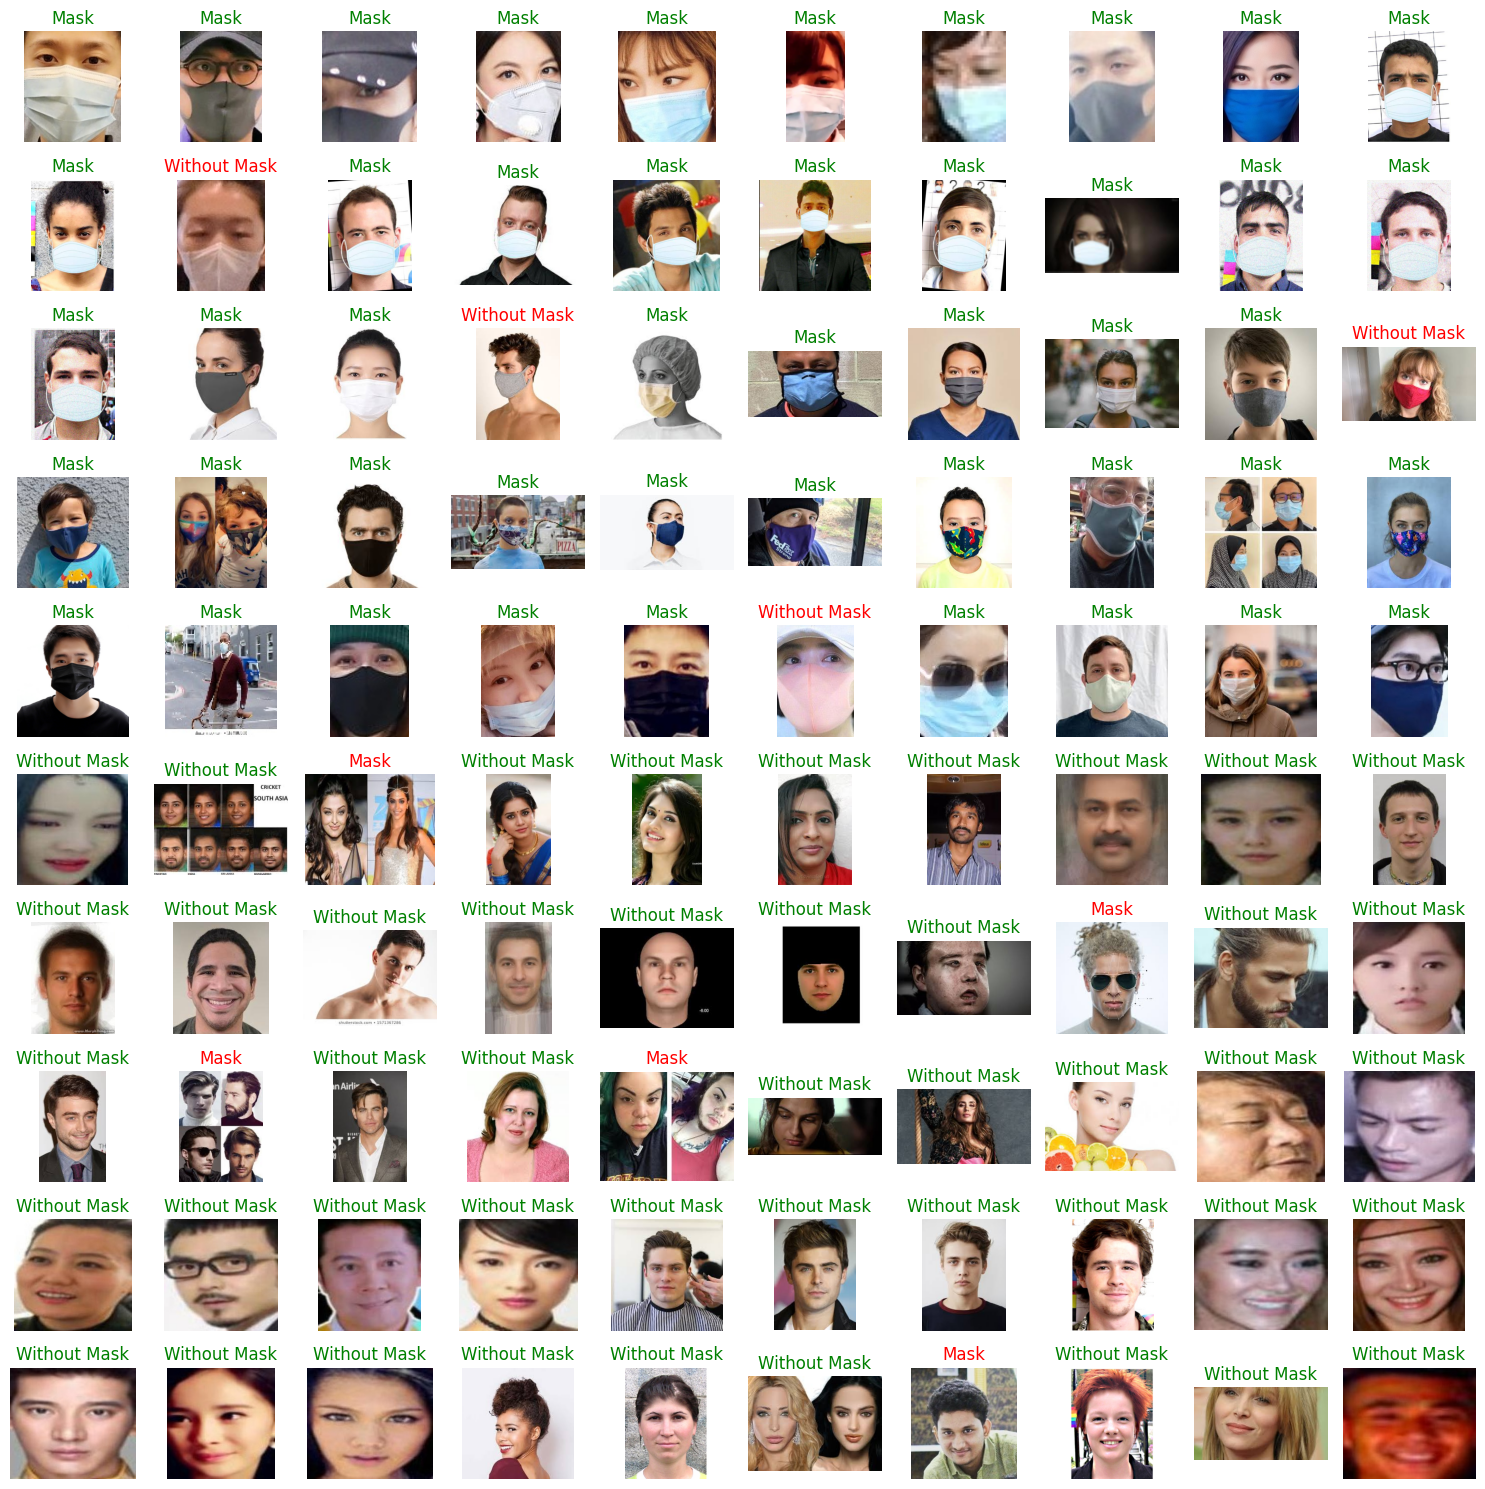

<Figure size 640x480 with 0 Axes>

In [ ]:
# Getting filenames from the testing set
filenames = test_generator.filenames

# Plottin each image with its predicted and true labels
plt.figure(figsize=(15, 15))

for i, filename in enumerate(filenames):
    # Loading the image
    img_path = os.path.join(testing_path, filename)
    img = plt.imread(img_path)

    # Plotting the image as the true labels
    plt.subplot(10, 10, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # ------------------ Printing wrong predicted labels in red so they're easier to spot

    predicted_label = 'Mask' if y_pred[i] == 0 else 'Without Mask'
    plt.title(predicted_label, color = 'green' if y_pred[i] == y[i] else 'red')

plt.tight_layout()
plt.show()

**Try to derive some conclusions from the wrong predictions that your model has made. Meaning: why do you think these predictions were wrong?**

Out of the 5 images wrongly classified as with mask, 3 are actaully a set of images combined in one, so the model might have missed details on the face. For the images wrongly classfied as without mask, it looks like the model confused the mask's color with the face's tone. This suggests that the model might be missing a few tricky details on the face.

**Think of a way that you can use in order to improve the performance of your model, and implement it**

I will try increasing the size of the input images to make sure more image details are clearer, and I will add a third convolutional layer with a larger filter.

In [ ]:
train_generator = training_datagen.flow_from_directory(
    training_path,
    target_size=(156,156),  # I will try resizing all images to 156x156
    batch_size=64,
    class_mode='binary'
)

# Doing the same for validation and testing data

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(156,156),
    batch_size=64,
    class_mode='binary'
)

test_generator = testing_datagen.flow_from_directory(
    testing_path,
    target_size=(156,156),
    batch_size=64,
    class_mode='binary',
    shuffle=False  # Not shuffling for testing (for consistent evaluation)
)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
model = models.Sequential([

    # Input layer
    layers.Input(shape=(156, 156, 3)),

    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Max pooling

    # Convolutional Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Extra Convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the feature maps
    layers.Flatten(),

    # Fully Connected Layer 1
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Fully Connected Layer 2 (Output Layer)
    layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(
    optimizer=Adam(learning_rate = 0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']  # Metrics to monitor classification performance
)

# Printting the model summary
model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)                   │ (None, 154, 154, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_84 (MaxPooling2D)      │ (None, 77, 77, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_85 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_85 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_86 (Conv2D)                   │ (None, 35, 35, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_86 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_36 (Flatten)                 │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,  # Training data generator
    validation_data=validation_generator,  # Validation data generator
    epochs=20,  # Number of epochs to train
    callbacks=[early_stopping]
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.5451 - loss: 0.6859 - precision: 0.5536 - recall: 0.5876 - val_accuracy: 0.8450 - val_loss: 0.5768 - val_precision: 0.8632 - val_recall: 0.8200
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.7354 - loss: 0.5878 - precision: 0.7371 - recall: 0.7447 - val_accuracy: 0.8350 - val_loss: 0.4253 - val_precision: 0.9467 - val_recall: 0.7100
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.7593 - loss: 0.5055 - precision: 0.7783 - recall: 0.7578 - val_accuracy: 0.8800 - val_loss: 0.3427 - val_precision: 0.9318 - val_recall: 0.8200
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.8004 - loss: 0.4832 - precision: 0.8157 - recall: 0.7722 - val_accuracy: 0.9000 - val_loss: 0.2956 - val_precision: 0.9082 - val_recall: 0.8900
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.8202 - loss: 0.4219 - precision: 0.8204 - recall: 0.8164 - val_accuracy: 0.9050 - val_loss: 0.2733 - val

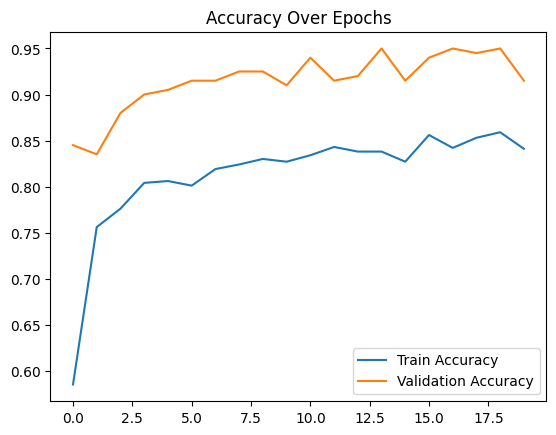

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")
print(f"Test Precision: {test_precision}, Test Recall: {test_recall}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.8717 - loss: 0.3287 - precision: 0.7918 - recall: 0.8962
Test Accuracy: 0.8700000047683716, Test Loss: 0.32291415333747864
Test Precision: 0.8627451062202454, Test Recall: 0.8799999952316284


The acuuracy decreased by almost 4% on testing data, however, this model looks much more stable than the previous one as suggested by the accuracy curves, especially the training one.  

**Your Friend took your code and ran it again, but obtained different accuracies on the different sets. How do you interpret this?**

The difference might be due to the random setting of the iniatailized weights or the randomness in how my model sees the data. Since I have not split the training, validation and testing using the train test split function (where we usually used to specify a random seed so that the data is always split in the same way), I think everytime the code runs, my model sees a different order of images in the batches. This could also be happening when the ImageDataGenerator is used for data augmentation, where the different augmentations are applied on different images everytime its called.  